In [1]:
%load_ext autoreload
%autoreload 2
#import plum
#plum.autoreload.activate()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json

from functools import partial, reduce

In [3]:
# Added to silence some warnings.
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

import flax
import optax

/opt/anaconda3/envs/q_embedding_new/lib/python3.8/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [4]:
import pennylane as qml
import netket as nk
from netket.operator.spin import sigmax,sigmaz

In [5]:
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=250)

In [6]:
from utils             import *
from hamiltonians      import *
from quantum_circuits  import *
from classic_models    import *
from truncated_spin    import Spin

## Ising - system and Hamiltonian

In [21]:
phys_qubits       = 3
n_classical_spins = 6

ancilla_qubits    = 1
tot_qubits        = phys_qubits + ancilla_qubits

q_index           = [i for i in range(n_classical_spins//2,n_classical_spins//2+phys_qubits)]
c_index           = [i for i in range(n_classical_spins//2)] + [i for i in range(n_classical_spins//2+phys_qubits, n_classical_spins+phys_qubits)]

device_phys         = qml.device("default.qubit.jax", wires=list(range(phys_qubits)))
device_with_ancilla = qml.device("default.qubit.jax", wires=list(range(phys_qubits))+["a"])

# Define the Hilbert space
hi = Spin(N=n_classical_spins//2, maximum_up=n_classical_spins//2,minimum_up=0)*Spin(N=n_classical_spins//2, maximum_up=n_classical_spins//2,minimum_up=0)

In [22]:
## Define the Hamiltonian

# Ising
hc = -1
hq = -1

j_c      = 0.25
j_q      = 1.0
j_int    = 0.5

h_list   = (n_classical_spins//2)*[hc] + (phys_qubits)*[hq] + (n_classical_spins//2)*[hc]

j_list   = (n_classical_spins//2 -1)*[j_c] + [j_int] + (phys_qubits - 1)*[j_q] + [j_int] +  (n_classical_spins//2 -1)*[j_c]
#h_mixed  = ising_hamiltonian_mixed(tot_spins,j_list,h_list,q_index)
hami_op_list, hami_coeff_list = generate_ising_hami_list(phys_qubits+n_classical_spins,j_list,h_list)

In [23]:
h_mixed = mixed_hami_from_list(hami_op_list,hami_coeff_list,hi,q_index,c_index)

Number of pure  quantum op: 5
Number of pure  classic op: 10
Number of       mixed   op: 2
Number of quantum    group: 2


## Exact energy of the GS 

In [24]:
hi_full    = nk.hilbert.Spin(s=1/2,N=phys_qubits+n_classical_spins) 

In [25]:
## Total Hamiltonian
htot_nk = netket_hami_from_list(hami_op_list,hami_coeff_list,hi_full)

In [26]:
## Ground state energy
E_gs, psi_gs = nk.exact.lanczos_ed(htot_nk, compute_eigenvectors=True)

In [27]:
E_gs[0]

-9.697821000506377

## Circuit

In [28]:
## Total circuit
depth   =  4
my_circ = (circ_pass, circ_classic_RY, partial(circ_RY ,depth))

In [29]:
## Print the circuit
draw_device = qml.device("default.qubit", list(range(phys_qubits))+["a"])

In [30]:
@qml.qnode(draw_device)
def draw_circuit(params,θ_σ,θ_η):
    
    my_circ[1](draw_device, params, θ_σ, θ_η)
    my_circ[2](draw_device,  params)
    
    return qml.state()

In [31]:
drawer = qml.draw(draw_circuit)
print(drawer(jnp.asarray(list(range(15))),jnp.asarray(list(range(5,7))),None))

0: ──RY(5.00)──||──RY(0.00)─╭●──RY(3.00)───────────╭●──RY(6.00)───────────╭●──RY(9.00)────────────╭●
1: ────────────||──RY(1.00)─╰X─╭●─────────RY(4.00)─╰X─╭●─────────RY(7.00)─╰X─╭●─────────RY(10.00)─╰X
2: ──RY(6.00)──||──RY(2.00)────╰X─────────RY(5.00)────╰X─────────RY(8.00)────╰X─────────RY(11.00)───

───RY(12.00)────────────┤  State
──╭●──────────RY(13.00)─┤  State
──╰X──────────RY(14.00)─┤  State


## Training 

### Define the classic models

In [32]:
time_seed = int(time.time())
seed      = jax.random.PRNGKey(time_seed)

In [33]:
########## Initialise RBM Spin Machine
ma       = nk.models.RBM(alpha=1, param_dtype=float)
ma_lin    = RBM_Linear(alpha=1, param_dtype=float)
# Random initialization
pars_c     = ma.init(jax.random.PRNGKey(time_seed), hi.random_state(seed, 1))
pars_c_lin = ma_lin.init(jax.random.PRNGKey(time_seed), hi.random_state(seed, 1))

## Initialise the sampler (fullsummation does not require a sampler)
#sa       = nk.sampler.MetropolisLocal(hi, n_chains=10)
sa       = nk.sampler.ExactSampler(hi)
sa_state = sa.init_state(ma, pars_c, seed)

In [34]:
########## Sample to angle machine
angles_a = 2  # Number of angles controlled in the circuit
alpha_a  = 2  # Numbers of nodes in the hidden layer of the NN
sta      = Sample_to_angle(alpha=alpha_a, angles=angles_a, param_dtype=float)
pars_a   = sta.init(jax.random.PRNGKey(time_seed), jnp.array([-1 for  i in range(n_classical_spins)]))

In [35]:
########## Quantum circuit
pars_q = np.random.rand(phys_qubits*(depth+1))

# Put quantum and classical params together
pars_all = flax.core.unfreeze(pars_c)
pars_all['quantum'] = pars_q
pars_all['angles']  = pars_a
pars_all = flax.core.freeze(pars_all)

### Optimizer

In [36]:
########### Declare the optimizer
# Mixed with SR
# using SGD if we choose to use SR in the classical parameters
sr       = True
unbiased = False # True if we want to use the unbiased estimator    


if sr:
    opt_classical = optax.sgd(0.01)
else:
    opt_classical = optax.adam(learning_rate=0.01) 

opt_quantum = optax.adam(learning_rate=0.01)
opt_angles  = optax.adam(learning_rate=0.01) 
optimizer   = optax.multi_transform({'o1': opt_classical, 'o2': opt_quantum,'o3': opt_angles}, flax.core.freeze({"params":"o1", "quantum":"o2", "angles":"o3"}))

opt_state = optimizer.init(pars_all)

## Optimization loop

In [37]:
## Loop info
n_steps    = 400
n_samples  = 8000

In [38]:
## Saving quantities 

## Total energies and errors
e_vec    = []
## Gradient 
grad_vec = []

In [40]:
# Save the best result

e_best     = 10
pars_best  = pars_all
sigma_best = 0
save_step  = 5

for step_c in range(n_steps):
    pars_ac, pars_q = pars_all.pop("quantum")
    pars_c, pars_a  = pars_ac.pop("angles")
    
    # Sample from the classical distribution
    
    sa_state        = sa.reset( ma, pars_c, sa_state)
    sigma, sa_state = sa.sample(ma, pars_c, state=sa_state, chain_length=n_samples)
    
    # Evaluate the energy both on classical and quantum computer
    energy, grad_e = e_tot_and_grad(ma, ma_lin, device_with_ancilla, my_circ, pars_all, sigma, sta, h_mixed,unbiased=unbiased)

    ## =================== SR for the classical gradient ===================
    if sr:

        grad_e_real = jax.tree_map(lambda x : x.real, grad_e)
        grad_e      = compute_SR(ma,sigma,grad_e_real,pars_c,diag_shift=0.001)
    
    #=======================================================================
    
        
    ## Print energy    
    if step_c % 50 == 0:
        
        print(f"Step {step_c}, energy: {energy.mean.real:.8f} +- {energy.error_of_mean:.8f}")
        print("--------------------------------------------------------------")
        
    e_vec.append(energy)
    grad_vec.append(grad_e)
    
    # Save the best results
    if energy.mean < e_best:
        e_best     = energy.mean
        pars_best  = pars_all
        sigma_best = sigma
    
   
    # With optax
    pars_all, opt_state = optimizer_step(optimizer,opt_state, grad_e, pars_all)
    
print(f"Final energy: {energy}")

Step 0, energy: -8.62256884 +- 0.00607692
--------------------------------------------------------------
Step 50, energy: -9.57908707 +- 0.00104343
--------------------------------------------------------------
Step 100, energy: -9.59787706 +- 0.00038955
--------------------------------------------------------------
Step 150, energy: -9.61193185 +- 0.00018728
--------------------------------------------------------------
Step 200, energy: -9.62778540 +- 0.00034421
--------------------------------------------------------------
Step 250, energy: -9.63683009 +- 0.00024604
--------------------------------------------------------------
Step 300, energy: -9.63983718 +- 0.00037936
--------------------------------------------------------------
Step 350, energy: -9.64198347 +- 0.00026352
--------------------------------------------------------------
Final energy: -9.64466-0.00000j ± 0.00029 [σ²=0.00065]


In [42]:
final_variational = e_tot(ma, device_with_ancilla, my_circ, pars_best, sigma_best.reshape(-1, sigma_best.shape[-1]), sta, h_mixed)
final_variational

-9.64466-0.00000j ± 0.00029 [σ²=0.00065]

## Plot data

#### Plot total energy

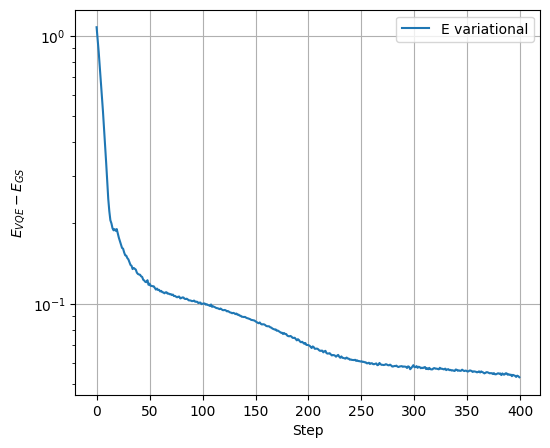

In [43]:
fig, ax = plt.subplots(1,figsize=[6.0,5.0],sharex=True)
e_tot_ref = E_gs


mean_e = np.asarray([np.real(energy.mean) for energy in e_vec])
err_e  = np.asarray([np.real(energy.error_of_mean) for energy in e_vec])
var_e  = np.asarray([np.real(energy.variance) for energy in e_vec])

n_opt  = list(range(len(mean_e)))



## Plot energy with error
ax.errorbar(n_opt,mean_e-e_tot_ref,label="E variational",color="C0")

ax.set_xlabel("Step")
ax.set_ylabel(r"$E_{VQE}-E_{GS}$")
ax.legend()
ax.grid()
ax.set_yscale("log")

fig.subplots_adjust(hspace=0.04)
plt.show()